In [2]:
import geopandas as gpd
import contextily as ctx
import pandas as pd
import matplotlib.pyplot as plt
import cartiflette.s3
import numpy as np
import matplotlib as mpl
import math
import unidecode


from geopandas import GeoDataFrame
from matplotlib import cm
from cartiflette.download import get_vectorfile_ign

In [3]:
df = pd.read_csv("Final Dataset MODS203.csv")
df = df.drop(columns=["Payment_accepted"])
df = df.dropna()
df = df.drop_duplicates()
df

,Name,Type,Speciality,Address,City,Postal_Code
0,Nathalie GARNIER-VIOUGEAT,Physician,Oncologue médical,23 Rue Georges Bizet 75016,Paris,75116
1,Service de chirurgie cancer ORL - Institut Curie,Hospital,Centre de Lutte Contre le Cancer (CLCC),26 Rue d'Ulm,Paris,75005
2,Fabio GIORGIANO,Physician,Chirurgien général,21 Rue Balzac,Paris,75008
3,Hôpital Cochin - AP-HP,Hospital,Hôpital public,123 Boulevard de Port-Royal,Paris,75014
4,Marc Spielmann,Physician,Cancérologue,22 bis rue Georges Bizet,Paris,75116
...,...,...,...,...,...,...
27301,Catherine PERONNET,Physician,Médecin généraliste,29 Avenue Henri Barbusse,Tremblay-en-France,93290
27302,Jacques BOHBOT,Physician,Médecin généraliste,29 Avenue Henri Barbusse,Tremblay-en-France,93290
27304,Centre Municipal de Santé - Mitry Mory,Hospital,Centre de santé,4 Place Nelson Mandela,Mitry-Mory,77290
27305,Dépistage COVID Aéroport Roissy Charles de Gau...,Hospital,Centre de dépistage COVID-19,Terminal 2,Roissy-en-France,95700


Use only the Paris urban periphery entries

In [4]:
n = 25711
idf = [75, 92, 93, 94]


for k in range (n):
    try :
        try :
            df['Postal_Code'][k] = int(np.floor(int(df['Postal_Code'][k])/1000))
            if not(df['Postal_Code'][k] in idf):
                df = df.drop(index=k)
        except :
            df = df.drop(index=k)
    except KeyError as err:
        print(k)            
df

20
24
25
26
28
29
30
32
35
37
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
73
74
75
77
78
80
81
82
83
90
91
92
93
94
95
97
99
100
101
102
103
104
105
106
107
108
110
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
173
174
175
176
177
178
179
181
182
183
186
187
188
190
191
192
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315


,Name,Type,Speciality,Address,City,Postal_Code
0,Nathalie GARNIER-VIOUGEAT,Physician,Oncologue médical,23 Rue Georges Bizet 75016,Paris,75
1,Service de chirurgie cancer ORL - Institut Curie,Hospital,Centre de Lutte Contre le Cancer (CLCC),26 Rue d'Ulm,Paris,75
2,Fabio GIORGIANO,Physician,Chirurgien général,21 Rue Balzac,Paris,75
3,Hôpital Cochin - AP-HP,Hospital,Hôpital public,123 Boulevard de Port-Royal,Paris,75
4,Marc Spielmann,Physician,Cancérologue,22 bis rue Georges Bizet,Paris,75
...,...,...,...,...,...,...
27301,Catherine PERONNET,Physician,Médecin généraliste,29 Avenue Henri Barbusse,Tremblay-en-France,93290
27302,Jacques BOHBOT,Physician,Médecin généraliste,29 Avenue Henri Barbusse,Tremblay-en-France,93290
27304,Centre Municipal de Santé - Mitry Mory,Hospital,Centre de santé,4 Place Nelson Mandela,Mitry-Mory,77290
27305,Dépistage COVID Aéroport Roissy Charles de Gau...,Hospital,Centre de dépistage COVID-19,Terminal 2,Roissy-en-France,95700


### Paris urban periphery map

In [5]:
shp_communes = cartiflette.s3.download_vectorfile_url_all(
    values = ["75", "92", "93", "94"],
    level="COMMUNE",
    vectorfile_format="GPKG",
    decoupage="departement",
    year=2022)

Downloading: : 116kiB [00:00, 1.77MiB/s]
Downloading: : 264kiB [00:00, 2.83MiB/s]
Downloading: : 436kiB [00:00, 3.73MiB/s]
Downloading: : 396kiB [00:00, 3.35MiB/s]


In [6]:
ilefr = shp_communes.drop('ID', axis=1, inplace=False).drop('INSEE_REG', axis=1, inplace=False).drop('NOM', axis=1, inplace=False).drop('POPULATION', axis=1, inplace=False).drop('STATUT', axis=1, inplace=False).drop('SIREN_EPCI', axis=1, inplace=False).drop('INSEE_CAN', axis=1, inplace=False).drop('INSEE_ARR', axis=1, inplace=False).drop('INSEE_DEP', axis=1, inplace=False)
ilefr.rename(columns = {'NOM_M':'City'}, inplace = True)
ilefr

,City,INSEE_COM,geometry
0,PARIS,75056,"POLYGON ((653313.800 6857558.100, 653249.300 6..."
0,LEVALLOIS-PERRET,92044,"POLYGON ((647761.400 6867306.900, 647839.200 6..."
1,BOIS-COLOMBES,92009,"POLYGON ((646224.700 6867615.800, 646229.000 6..."
2,MALAKOFF,92046,"POLYGON ((646995.300 6857373.400, 647177.500 6..."
3,CLICHY,92024,"POLYGON ((648952.800 6866241.200, 648865.900 6..."
...,...,...,...
42,MAISONS-ALFORT,94046,"POLYGON ((657111.400 6857512.100, 657136.900 6..."
43,MANDRES-LES-ROSES,94047,"POLYGON ((665181.400 6845053.400, 665181.000 6..."
44,NOGENT-SUR-MARNE,94052,"POLYGON ((663122.500 6859090.100, 663086.400 6..."
45,SUCY-EN-BRIE,94071,"POLYGON ((664177.200 6853965.900, 664262.100 6..."


In [7]:
paris = df.drop('Address', axis=1, inplace=False).drop('Speciality', axis=1, inplace=False).drop('Type', axis=1, inplace=False).drop('Postal_Code', axis=1, inplace=False)
paris = paris.groupby(by='City', as_index=False).agg({'Name': pd.Series.nunique})
paris.sort_values('City', ascending = False)

,City,Name
206,Ézanville,1
205,Évry-Courcouronnes,5
204,Évry,2
203,Épinay-sur-Seine,21
202,Épinay-sous-Sénart,3
...,...,...
4,Arnouville,2
3,Arcueil,6
2,Antony,64
1,Alfortville,26


In [8]:
for cit in paris['City']:
        paris['City'] = paris['City'].replace([cit], (unidecode.unidecode(cit)).upper())
paris

,City,Name
0,ABLON-SUR-SEINE,3
1,ALFORTVILLE,26
2,ANTONY,64
3,ARCUEIL,6
4,ARNOUVILLE,2
...,...,...
202,EPINAY-SOUS-SENART,3
203,EPINAY-SUR-SEINE,21
204,EVRY,2
205,EVRY-COURCOURONNES,5


In [9]:
ilefr = GeoDataFrame(pd.merge(paris, ilefr, on='City', how='right'))
ilefr['Name'] = ilefr.groupby(['INSEE_COM'])['Name'].transform('sum')
ilefr

,City,Name,INSEE_COM,geometry
0,PARIS,1488.0,75056,"POLYGON ((653313.800 6857558.100, 653249.300 6..."
1,PARIS,1488.0,75056,"POLYGON ((653313.800 6857558.100, 653249.300 6..."
2,LEVALLOIS-PERRET,60.0,92044,"POLYGON ((647761.400 6867306.900, 647839.200 6..."
3,BOIS-COLOMBES,8.0,92009,"POLYGON ((646224.700 6867615.800, 646229.000 6..."
4,MALAKOFF,4.0,92046,"POLYGON ((646995.300 6857373.400, 647177.500 6..."
...,...,...,...,...
125,MAISONS-ALFORT,39.0,94046,"POLYGON ((657111.400 6857512.100, 657136.900 6..."
126,MANDRES-LES-ROSES,0.0,94047,"POLYGON ((665181.400 6845053.400, 665181.000 6..."
127,NOGENT-SUR-MARNE,34.0,94052,"POLYGON ((663122.500 6859090.100, 663086.400 6..."
128,SUCY-EN-BRIE,7.0,94071,"POLYGON ((664177.200 6853965.900, 664262.100 6..."


In [10]:
color_used = cm.get_cmap('turbo')
tab_colors = color_used(np.linspace(0, 1, 101))

def give_color2(nb):
    if nb > 100:
        nb = 100
    nb_norm = (nb)/(100)
    nb_norm = round(nb_norm*100)
    return(list(tab_colors[nb_norm]))

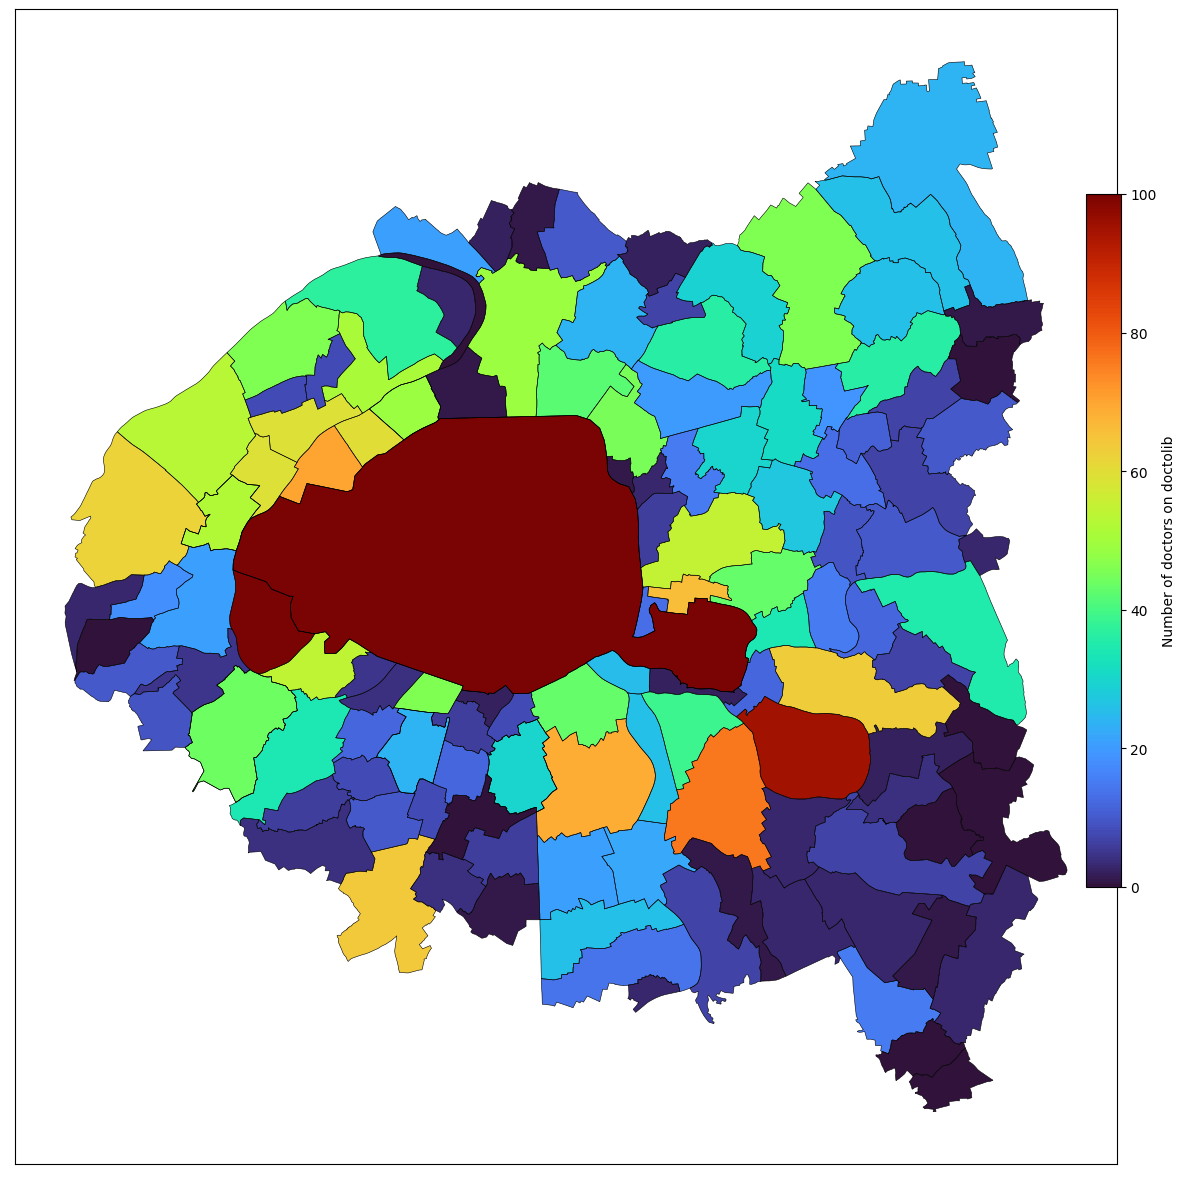

In [11]:
fig = plt.figure(1, figsize=(25,15))
ax = fig.add_subplot()

for k in range (len(ilefr['City'])):
    current_state = ilefr[ilefr.index.isin([k])]
    current_state.boundary.plot(ax=ax, color='Black', linewidth=.4)
    if math.isnan(current_state['Name']):
        current_state.plot(ax=ax, color= give_color2(0), figsize=(12, 12))
    else : 
        current_state.plot(ax=ax, color= give_color2(int(current_state['Name'])), figsize=(12, 12))

plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=100, clip=False), cmap='turbo'),label="Number of doctors on doctolib", orientation="vertical", shrink = 0.6, anchor =(-0.50, 0.6))
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)